In [ ]:
from google.colab import drive
import warnings
warnings.filterwarnings('ignore')
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
abspath='/content/drive/MyDrive/capstone-netflix/'

In [ ]:
import tensorflow as tf
import pandas as pd
import re
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_datasets as tfds
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.corpus import stopwords 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,log_loss
from sklearn.feature_extraction.text import TfidfTransformer
import nltk
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
import pickle
from sklearn.svm import SVC 
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from keras.layers import LSTM,Dense,Bidirectional,Input
from keras.models import Model
from tensorflow.keras.optimizers import Adam

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
review = pd.read_csv(abspath+"IMDB review.csv")

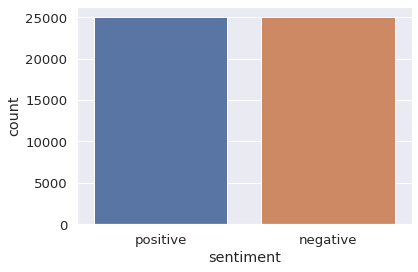

In [ ]:
sns.set(style = "darkgrid" , font_scale = 1.2)
sns.countplot(review.sentiment)

In [ ]:
review.sentiment = [ 1 if each == "positive" else 0 for each in review.sentiment]

In [ ]:
le = LabelEncoder()

In [ ]:
review['review'] = review['review'].apply(lambda x: re.sub('[,\.!?:()"]', '', x))
review['review'] = review['review'].apply(lambda x: re.sub('[^a-zA-Z"]', ' ', x))
review['review'] = review['review'].apply(lambda x: x.lower())

In [ ]:
#removing the stopwords
stop_words = set(stopwords.words('english')) 
tokenizer=ToktokTokenizer()
def remove_stopwords(corpus):
    tokens = tokenizer.tokenize(corpus)
    tokens = [token.strip() for token in tokens]
    new_tokens = [token for token in tokens if token.lower() not in stop_words]
    new_text = ' '.join(new_tokens)    
    return new_text
#Apply function on review column
review['review']=review['review'].apply(remove_stopwords)

In [ ]:
train_review,test_review,train_y,test_y  = train_test_split(review['review'].values,review['sentiment'].values,test_size = 0.2)
train_y_tran = le.fit_transform(train_y)
test_y_tran = le.fit_transform(test_y)

In [ ]:
tokenizer = Tokenizer(num_words=15000,oov_token='<OOV>')
tokenizer.fit_on_texts(train_review)
word_index = tokenizer.word_index

In [ ]:
train_sequence = tokenizer.texts_to_sequences(train_review)
test_sequence = tokenizer.texts_to_sequences(test_review)
train_pad_sequence = pad_sequences(train_sequence,maxlen = 200,truncating= 'post',padding = 'pre')
test_pad_sequence = pad_sequences(test_sequence,maxlen = 200,truncating= 'post',padding = 'pre')
print('Total Unique Words : {}'.format(len(word_index)))

Total Unique Words : 110682


In [ ]:
embedded_words = {}
# with open('glove.6B.200d.txt') as file:
with open('/content/drive/MyDrive/capstone-netflix/glove.6B.200d.txt') as file:
    for line in file:
        words, coeff = line.split(maxsplit=1)
        coeff = np.array(coeff.split(),dtype = float)
        embedded_words[words] = coeff

In [ ]:
embedding_matrix = np.zeros((len(word_index) + 1,200))
for word, i in word_index.items():
    embedding_vector = embedded_words.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
LSTM_model = tf.keras.Sequential([tf.keras.layers.Embedding(len(word_index) + 1,200,weights=[embedding_matrix],input_length=200,
                            trainable=False),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
                             tf.keras.layers.Dropout(0.3),
                             tf.keras.layers.Dense(256,activation = 'relu',),
                             tf.keras.layers.Dense(128,activation = 'relu'),
                             tf.keras.layers.Dropout(0.3),
                             tf.keras.layers.Dense(1,activation = tf.nn.sigmoid)])

In [ ]:
LSTM_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 200)          22136600  
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               135680    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               33024     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1

In [ ]:
LSTM_model.compile(loss = tf.keras.losses.BinaryCrossentropy() , optimizer='Adam' , metrics = 'accuracy')
LSTM_history = LSTM_model.fit(train_pad_sequence,train_y_tran,epochs = 6 ,validation_data=(test_pad_sequence,test_y_tran))

Epoch 1/6
1250/1250 [==============================] - 60s 21ms/step - loss: 0.5194 - accuracy: 0.7355 - val_loss: 0.3695 - val_accuracy: 0.8461
Epoch 2/6
1250/1250 [==============================] - 24s 20ms/step - loss: 0.3527 - accuracy: 0.8513 - val_loss: 0.3149 - val_accuracy: 0.8659
Epoch 3/6
1250/1250 [==============================] - 24s 19ms/step - loss: 0.2952 - accuracy: 0.8796 - val_loss: 0.2946 - val_accuracy: 0.8756
Epoch 4/6
1250/1250 [==============================] - 24s 19ms/step - loss: 0.2698 - accuracy: 0.8897 - val_loss: 0.2853 - val_accuracy: 0.8830
Epoch 5/6
1250/1250 [==============================] - 24s 19ms/step - loss: 0.2374 - accuracy: 0.9040 - val_loss: 0.2853 - val_accuracy: 0.8862
Epoch 6/6
1250/1250 [==============================] - 24s 19ms/step - loss: 0.2050 - accuracy: 0.9190 - val_loss: 0.3041 - val_accuracy: 0.8750


<Figure size 432x288 with 0 Axes>

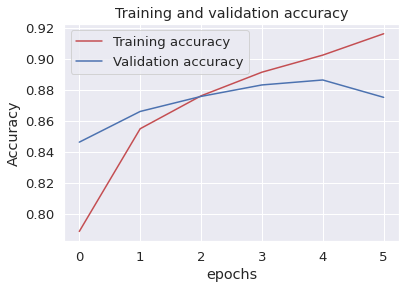

<Figure size 432x288 with 0 Axes>

In [ ]:
LSTM_acc = LSTM_history.history['accuracy']
LSTM_val_acc = LSTM_history.history['val_accuracy']
LSTM_loss = LSTM_history.history['loss']
LSTM_val_loss = LSTM_history.history['val_loss']
LSTM_epochs = range(len(LSTM_acc))

plt.plot(LSTM_epochs, LSTM_acc, 'r', label='Training accuracy')
plt.plot(LSTM_epochs, LSTM_val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.legend(loc=0)
plt.figure()


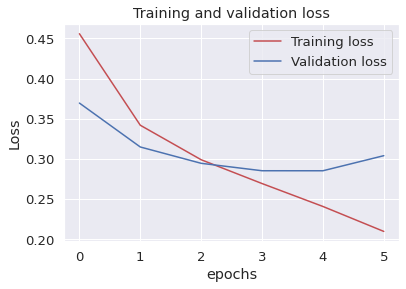

In [ ]:
plt.plot(LSTM_epochs, LSTM_loss, 'r', label='Training loss')
plt.plot(LSTM_epochs, LSTM_val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend(loc=0)
plt.show()

In [ ]:
print('Training Accuracy: {}'.format(max(LSTM_acc)))
print('Validation Accuracy: {}'.format(max(LSTM_val_acc)))

Training Accuracy: 0.9160249829292297
Validation Accuracy: 0.8862000107765198


In [ ]:
LSTM_pred = LSTM_model.predict(test_pad_sequence)
LSTM_pred = np.round(LSTM_pred).astype(int)

In [ ]:
LSTM_cm = confusion_matrix(le.fit_transform(test_y),le.fit_transform(LSTM_pred))

Text(63.5, 0.5, 'Actual Reviews')

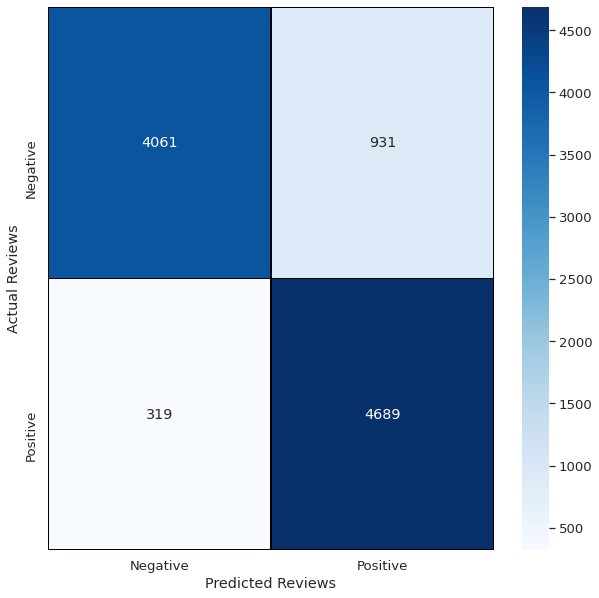

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(LSTM_cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Negative','Positive'] , yticklabels = ['Negative','Positive'])
plt.xlabel("Predicted Reviews")
plt.ylabel("Actual Reviews")

SVM

In [ ]:
def feature_extraction(data):
    tfv=TfidfVectorizer(sublinear_tf=True, stop_words = "english")
    features=tfv.fit_transform(data)
    pickle.dump(tfv.vocabulary_, open("svm_feature.pkl", "wb"))
    return features

In [ ]:
def preprocess(sample):
    sample.lower()
    sample = re.sub('[,\.!?:()"]','',sample)
    sample = re.sub('[^a-zA-Z"]','', sample)
    sample = re.sub('[\s]+', ' ', sample)
    tokens = word_tokenize(sample)
    tokens = [w for w in tokens if not w in stop_words]
    return " ".join(tokens)

In [ ]:
data = np.array(review.review)
label = np.array(review.sentiment)
features = feature_extraction(data)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(features, label, test_size = 0.20) 

In [ ]:
svclassifier = SVC(kernel='linear')  
svclassifier.fit(X_train, Y_train) 

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
svm_pred = svclassifier.predict(X_test)
print('Validation Accuract is: ', accuracy_score(Y_test, svm_pred))
print('Validation Loss is:', log_loss(Y_test, svm_pred))

Validation Accuract is:  0.8958
Validation Loss is: 3.5989862373227006


In [ ]:
#save svm model
filename = 'svm_model.sav'
pickle.dump(svclassifier, open(filename, 'wb'))

In [ ]:
loaded_model = pickle.load(open(filename, 'rb'))

In [ ]:
# sample1 = "3 Idiots is an evergreen Bollywood movie. The Aamir Khan starrer movie is a great mixture of several genre like comedy ,drama and romance.  I highly recommend this movie. The movie talks about several life experiences in humorous tones. Other great actors like Sharman Joshi aka 'Raju' , Madhavan aka 'Farhan' , Omi Vaidya as 'Silencer' , KKK as 'Piya' and Boman Irani as 'Virus' made this movie a huge success."
sample1 = 'My friend showed me this movie a few months ago, And we watched the 2nd movie, I thought that Noah and Elles relationship was cute and romantic. Until I watched the first one and re-watched the second one, I dont get why Elle chose Noah at the end of the first movie and the second one, He controls Elle so much, I agree with Lees perspective about their relationship, Why would Noah not let any other guy be with Elle, When he hooks up with every girl in their high school. Now onto Elle, In the second movie she has a dance competition with new kid Marco, And when they finish they kiss, And Noah leaves the building because obviously he would be mad, And Elle tries having him forgive her, WHY WOULD HE YOU KISSED ANOTHER BOY AND YOU ARE IN A RELATIONSHIP. If I could get rid of The Kissing Booth 1 off Netflix, I would, Watch a better movie like Enola Holmes.'
sample1 = preprocess(sample1)
sample1 = np.array([sample1])

In [ ]:
transformer = TfidfTransformer()
tfv_loaded = TfidfVectorizer(sublinear_tf=True, stop_words = "english", vocabulary=pickle.load(open("svm_feature.pkl", "rb")))
text = transformer.fit_transform(tfv_loaded.fit_transform(sample1))
polarity = loaded_model.predict(text)
print(polarity)

[0]


In [ ]:
SVM_history = svclassifier.fit(X_train,Y_train)

In [ ]:
SVM_acc = SVM_history.history['accuracy']
SVM_val_acc = SVM_history.history['val_accuracy']
SVM_loss = SVM_history.history['loss']
SVM_val_loss = SVM_history.history['val_loss']
SVM_epochs = range(len(SVM_acc))

plt.plot(SVM_epochs, SVM_acc, 'r', label='Training accuracy')
plt.plot(SVM_epochs, SVM_val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.legend(loc=0)
plt.figure()

In [ ]:
svm_cm = confusion_matrix(le.fit_transform(Y_test),le.fit_transform(svm_pred))

Text(63.5, 0.5, 'Actual')

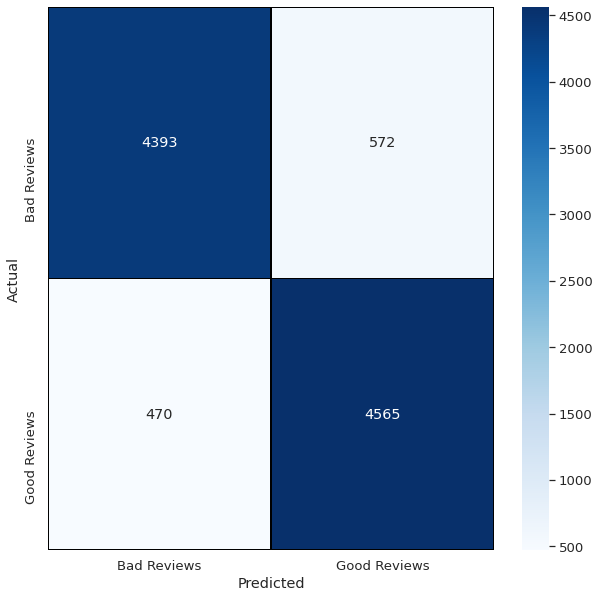

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(svm_cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Bad Reviews','Good Reviews'] , yticklabels = ['Bad Reviews','Good Reviews'])
plt.xlabel("Predicted")
plt.ylabel("Actual")

BERT

In [ ]:
!pip install transformers sentencepiece
!pip install tokenizers
from tokenizers import BertWordPieceTokenizer
import transformers
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased' , lower = True)
# Save the loaded tokenizer locally
tokenizer.save_pretrained('.')
# Reload it with the huggingface tokenizers library
bert_tokenizer = BertWordPieceTokenizer('vocab.txt', lowercase=True)
bert_tokenizer

     |████████████████████████████████| 2.1MB 15.7MB/s 
     |████████████████████████████████| 1.2MB 57.1MB/s 
     |████████████████████████████████| 901kB 50.6MB/s 
     |████████████████████████████████| 3.3MB 55.8MB/s 


Tokenizer(vocabulary_size=30522, model=BertWordPiece, unk_token=[UNK], sep_token=[SEP], cls_token=[CLS], pad_token=[PAD], mask_token=[MASK], clean_text=True, handle_chinese_chars=True, strip_accents=None, lowercase=True, wordpieces_prefix=##)

In [ ]:
def fast_encode(texts, tokenizer):

    tokenizer.enable_truncation(max_length=400)
    tokenizer.enable_padding()
    all_ids = []
    
    for i in range(0, len(texts), 256):
        text_chunk = texts[i:i+256].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])
    
    return np.array(all_ids)

In [ ]:
review = pd.read_csv(abspath+"IMDB review.csv")
review.sentiment = [ 1 if each == "positive" else 0 for each in review.sentiment]
train_review,test_review,train_y,test_y  = train_test_split(review['review'],review['sentiment'],test_size = 0.2)

In [ ]:
x_train = fast_encode(train_review.values, bert_tokenizer)
x_test = fast_encode(test_review.values, bert_tokenizer)

In [ ]:
def buildmodel(transformer):
    
    id = Input(shape=(400,), dtype=tf.int32, name="id")
    output = transformer(id)[0]
    token = output[:, 0, :]
    out = Dense(1, activation='sigmoid')(token)
    
    model = Model(inputs=id, outputs=out)
    model.compile(Adam(lr=2e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
bert1 = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased')

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_projector', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [ ]:
bert = buildmodel(bert1)
bert.summary()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experi

In [ ]:
history = bert.fit(x_train,train_y,batch_size = 32 ,validation_data=(x_test,test_y),epochs = 3)

Epoch 1/3
1250/1250 [==============================] - 1844s 1s/step - loss: 0.3101 - accuracy: 0.8558 - val_loss: 0.2018 - val_accuracy: 0.9210
Epoch 2/3
1250/1250 [==============================] - 1839s 1s/step - loss: 0.1462 - accuracy: 0.9451 - val_loss: 0.1956 - val_accuracy: 0.9270
Epoch 3/3
1250/1250 [==============================] - 1841s 1s/step - loss: 0.0812 - accuracy: 0.9715 - val_loss: 0.2117 - val_accuracy: 0.9279


In [ ]:
print("Accuracy of the model on Testing Data is " , bert.evaluate(x_test,test_y)[1]*100 , "%")

313/313 [==============================] - 143s 457ms/step - loss: 0.2117 - accuracy: 0.9279
Accuracy of the model on Testing Data is  92.79000163078308 %


<Figure size 432x288 with 0 Axes>

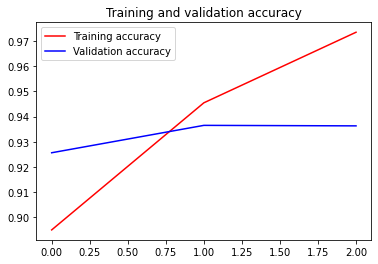

<Figure size 432x288 with 0 Axes>

In [ ]:
bert_epochs = [i for i in range(3)]
bert_train_acc = history.history['accuracy']
bert_train_loss = history.history['loss']
bert_val_acc = history.history['val_accuracy']
bert_val_loss = history.history['val_loss']

bert_acc = history.history['accuracy']
bert_val_acc = history.history['val_accuracy']
bert_loss = history.history['loss']
bert_val_loss = history.history['val_loss']
bert_epochs = range(len(bert_acc))

plt.plot(bert_epochs, bert_acc, 'r', label='Training accuracy')
plt.plot(bert_epochs, bert_val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

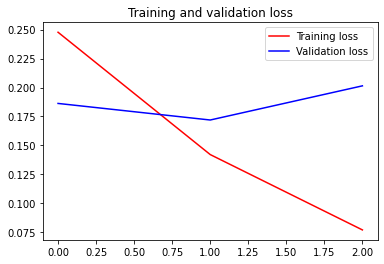

In [ ]:
plt.plot(bert_epochs, bert_loss, 'r', label='Training loss')
plt.plot(bert_epochs, bert_val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)

plt.show()

In [ ]:
bert_pred_ori = bert.predict(x_test)
bert_pred = np.round(bert_pred_ori).astype(int)
bert_cm = confusion_matrix(test_y,bert_pred)

Text(69.0, 0.5, 'Actual Reviews')

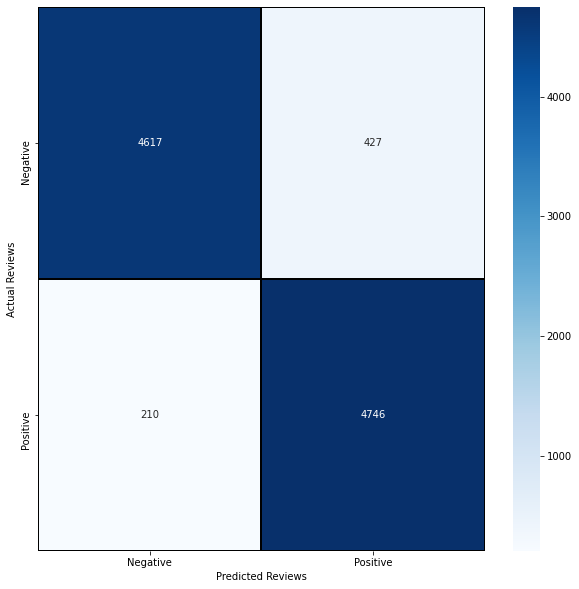

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(bert_cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Negative','Positive'] , yticklabels = ['Negative','Positive'])
plt.xlabel("Predicted Reviews")
plt.ylabel("Actual Reviews")

In [ ]:
test_review.values

array(["Renee Zellweger absolutely shines as Nurse Betty, easily one of the most charming, off-beat, and lighthearted comedies of the year.<br /><br />When soap opera obsessed waitress Betty Sizemore witnesses her insensitive husband's murder by two hitmen (Morgan Freeman and Chris Rock), she snaps and thinks the cast members on A Reason to Love are real. She decides to travel to Los Angeles to find famed heart specialist Dr. David Ravell (a character on the show).<br /><br />As the two oddly paired Hitmen, the caustic Rock and the pontificating Freeman generate some very fun chemistry, and Greg Kinnear also has fun with his smarmy offscreen actor persona. Renee Zellweger turns in an innocent, candy-coated, and sometimes terribly sweet performance as Nurse Betty. She exudes goodness, warmth, and is irresistible. While the script sometimes feels like a sit-com, is filled with sometimes unbelievable characters and contrived situations, Zellweger is so likeable and so utterly disarming th

In [ ]:
text_sample = np.array(['My one of the favourite lines from the movie was...joker saying to himself,,,"I used to think that my life is a TRAGEDY but now i realise that it is nothing but COMEDY"....so, u can imagine how disturbing a movie could be with its theme being TRAGEDY=COMEDY...but it was not that disturbing for me as i am used to of or aware of the ongoing social-political structure of our country','"It has dwarfs, music, Technicolor, freak characters, and Judy Garland. It cant be expected to have a sense of humor as well, and as for the light touch of fantasy, it weighs like a pound of fruitcake soaking wet.'])
text_sample_encoder = fast_encode(text_sample, bert_tokenizer)


In [ ]:
test_review_ind = np.array(test_review)

In [ ]:
test_review_ind[3]

'This is an excellent movie that tackles the issue of racism in a delicate and balanced way. Great performances all round but absolutely outstanding acting by Sidney Poitier.<br /><br />He makes this movie breathe and alive. His portrayal of a guy who struggles against discrimination and violence is simply mind blowing. His acting is forceful and delicate and subtle at the same time. Truly worthy of an Oscar, Poitier had to wait (because of his skin colour) for many more years before the sheer brilliance of his acting was recognised by the Academy.<br /><br />Cassavetes turns in a great performance too, withdrawn, troubled and realistic as it has become his hallmark. He and Poitier contrast inimitably the forces of cowardice, courage and human transformation through friendship.<br /><br />The movie is enjoyable and at the same time deeply haunting in its portrayal of racism in the US. The irony is that it somehow mirrors the realities under which Poitier had to work.'

In [ ]:
bert_pred_ori[3]

array([0.9997967], dtype=float32)